In [1]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
import copy
import numpy as np

from DataExtractor import DataExtractor
from DataExtractor import get_empty_dataset
from DataExtractor import merge_datasets

torch.manual_seed(3)

outputFolderName = 'Results/'

input_lags = 8 # The number of time lags. The number of input time steps
output_lags = 10 # was originally 1

def data_loader(flip=0, rotate=0, pathPrefix='./pdelab_data/build/output', normalizationFactor=0.01):
    loader = DataExtractor(flip=flip, rotate=rotate, pathPrefix=pathPrefix, normalizationFactor=normalizationFactor)
    dataset = loader.get_dataset(input_lags=input_lags, output_lags=output_lags)
    #train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)
    train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)
    return train_dataset, test_dataset

def plot_loss(train_loss_arr, valid_loss_arr, filename=''):
    x_range = [*range(5, len(train_loss_arr) * 5 + 5, 5)]
    plt.figure(figsize=(6, 6))
    plt.plot(x_range, train_loss_arr)
    plt.plot(x_range, valid_loss_arr)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(["Training", "Validation"], loc ="upper right")
    if filename != '':
        plt.savefig(outputFolderName + filename + '.eps', format='eps')

def plot_heatmaps(A, B, filenamePrefix=''):
    # TODO: Use maxVal and minVal to have the same range for both the plots
    maxVal = np.max((np.max(A), np.max(B)))
    minVal = np.min((np.min(A), np.min(B)))

    plt.figure(figsize=(6, 6))
    plt.imshow(A.reshape(10, 10), cmap='hot', interpolation='nearest')
    if filenamePrefix != '':
        plt.savefig(outputFolderName + filenamePrefix + "_targ.eps", format='eps')

    plt.figure(figsize=(6, 6))
    plt.imshow(B.reshape(10, 10), cmap='hot', interpolation='nearest')
    if filenamePrefix != '':
        plt.savefig(outputFolderName + filenamePrefix + "_pred.eps", format='eps')

# Model:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        #self.recurrent = DCRNN(node_features, 32, 1)
        self.recurrent = GConvGRU(node_features, 32, 2)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = self.relu(h)
        h = self.relu(h)
        h = self.linear(h)
        return h

def calculate_validation_loss(model, test_dataset):
    model.eval() # Switch to evaluation mode
    cost = 0
    for time, snapshot in enumerate(test_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    model.train() # Switch back to training mode
    return cost.item()

def training(model, train_dataset, test_dataset, num_epochs, trainingName):
    train_loss_arr = []
    valid_loss_arr = []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in tqdm(range(num_epochs)):
        cost = 0
        for time, snapshot in enumerate(train_dataset):
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            cost = cost + torch.mean((y_hat-snapshot.y)**2)
        cost = cost / (time+1)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 5 == 0:
            train_loss_arr.append(cost.item())
            valid_loss = calculate_validation_loss(model, test_dataset)
            valid_loss_arr.append(valid_loss)

            if epoch == 0:
                best_model = copy.deepcopy(model)
                best_valid_loss = valid_loss

            if best_valid_loss > valid_loss:
                best_model = copy.deepcopy(model)
                best_valid_loss = valid_loss


    plot_loss(train_loss_arr, valid_loss_arr, filename="loss"+trainingName)
    return (best_model, best_valid_loss)

In [2]:
model = RecurrentGCN(node_features=input_lags)
summary(model)

Layer (type:depth-idx)                   Param #
├─GConvGRU: 1-1                          --
|    └─ChebConv: 2-1                     --
|    |    └─ModuleList: 3-1              512
|    └─ChebConv: 2-2                     --
|    |    └─ModuleList: 3-2              2,048
|    └─ChebConv: 2-3                     --
|    |    └─ModuleList: 3-3              512
|    └─ChebConv: 2-4                     --
|    |    └─ModuleList: 3-4              2,048
|    └─ChebConv: 2-5                     --
|    |    └─ModuleList: 3-5              512
|    └─ChebConv: 2-6                     --
|    |    └─ModuleList: 3-6              2,048
├─ReLU: 1-2                              --
├─Linear: 1-3                            33
Total params: 7,713
Trainable params: 7,713
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─GConvGRU: 1-1                          --
|    └─ChebConv: 2-1                     --
|    |    └─ModuleList: 3-1              512
|    └─ChebConv: 2-2                     --
|    |    └─ModuleList: 3-2              2,048
|    └─ChebConv: 2-3                     --
|    |    └─ModuleList: 3-3              512
|    └─ChebConv: 2-4                     --
|    |    └─ModuleList: 3-4              2,048
|    └─ChebConv: 2-5                     --
|    |    └─ModuleList: 3-5              512
|    └─ChebConv: 2-6                     --
|    |    └─ModuleList: 3-6              2,048
├─ReLU: 1-2                              --
├─Linear: 1-3                            33
Total params: 7,713
Trainable params: 7,713
Non-trainable params: 0

# Training without Continual Learning

100%|██████████| 100/100 [13:48<00:00,  8.28s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


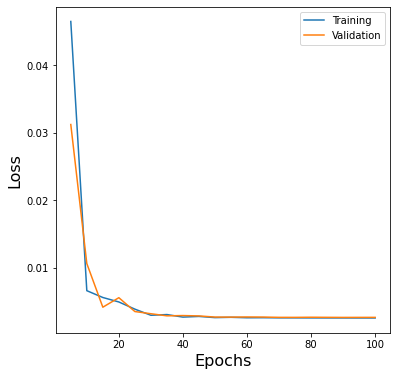

In [3]:
train_dataset, test_dataset = data_loader()
(model, best_valid_loss) = training(model, train_dataset, test_dataset, 100, 'originalDataset')

Validation loss on original dataset after training the model on the original dataset: 0.002665684325620532


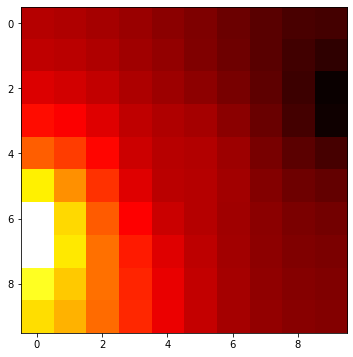

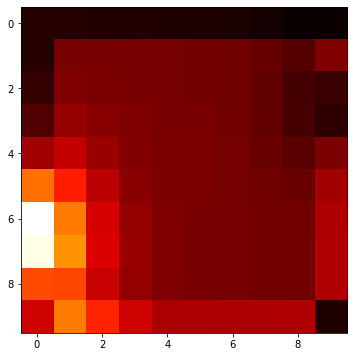

In [4]:
print(f'Validation loss on original dataset after training the model on the original dataset: {best_valid_loss}')

i = 100
y_hat = model(test_dataset[i].x, test_dataset[i].edge_index, test_dataset[i].edge_attr)
plot_heatmaps(test_dataset[i].y.detach().numpy(), y_hat.detach().numpy(), 'originalTrainedOnOriginal')

Validation loss on new dataset after training the model on the original dataset: 0.33640074729919434


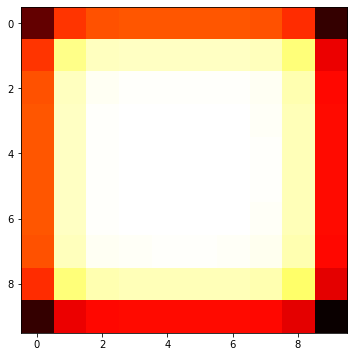

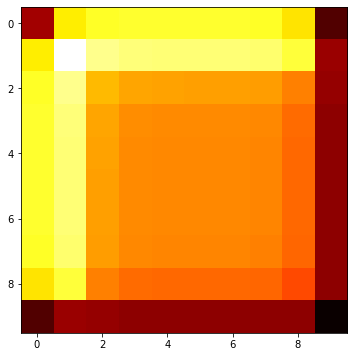

In [5]:
train_dataset_new, test_dataset_new = data_loader(flip=1, rotate=1, pathPrefix='./hpc_data/serial/output', normalizationFactor=1)
pre_train_valid_loss_new = calculate_validation_loss(model, test_dataset_new)
print(f'Validation loss on new dataset after training the model on the original dataset: {pre_train_valid_loss_new}')

i = 100
y_hat = model(test_dataset_new[i].x, test_dataset_new[i].edge_index, test_dataset_new[i].edge_attr)
plot_heatmaps(test_dataset_new[i].y.detach().numpy(), y_hat.detach().numpy(), 'newTrainedOnOriginal')

100%|██████████| 100/100 [17:17<00:00, 10.37s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Validation loss on new dataset after training the model on the new dataset: 0.034382838755846024
Validation loss on original dataset after training the model on the new dataset: 0.013849417679011822


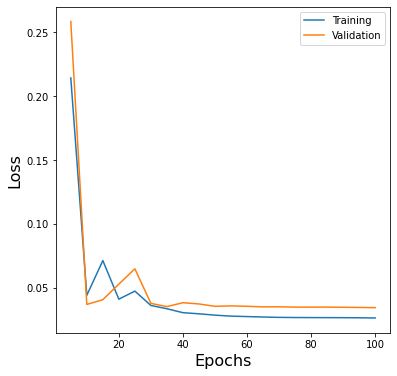

In [6]:
(model, best_valid_loss) = training(model, train_dataset_new, test_dataset_new, 100, 'newDataset')
print(f'Validation loss on new dataset after training the model on the new dataset: {best_valid_loss}')

post_train_origset_valid_loss = calculate_validation_loss(model, test_dataset)
print(f'Validation loss on original dataset after training the model on the new dataset: {post_train_origset_valid_loss}')

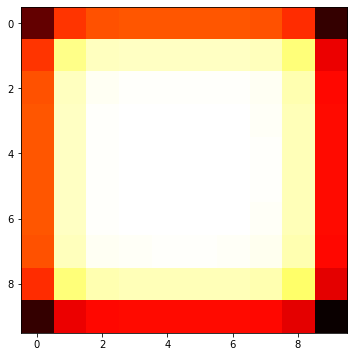

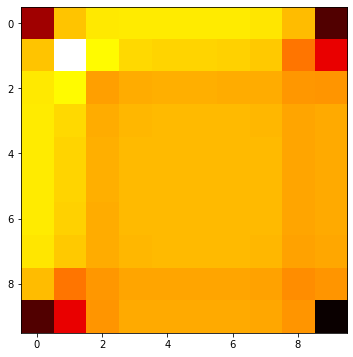

In [7]:
i = 100
y_hat = model(test_dataset_new[i].x, test_dataset_new[i].edge_index, test_dataset_new[i].edge_attr)
plot_heatmaps(test_dataset_new[i].y.detach().numpy(), y_hat.detach().numpy(), 'newTrainedOnNew')

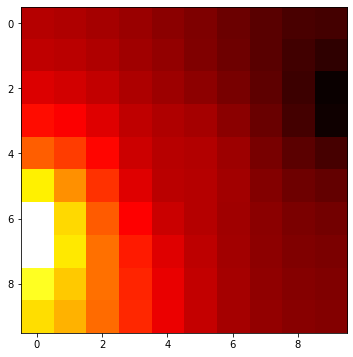

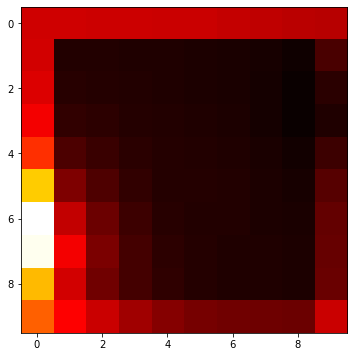

In [8]:
i = 100
y_hat = model(test_dataset[i].x, test_dataset[i].edge_index, test_dataset[i].edge_attr)
plot_heatmaps(test_dataset[i].y.detach().numpy(), y_hat.detach().numpy(), 'oldTrainedOnNew')

# Training with Continual Learning

In [9]:
learning_rate = 0.01
def training_continual(model_continual, train_dataset, test_dataset, num_epochs, trainingName):
    train_loss_arr = []
    valid_loss_arr = []

    optimizer = torch.optim.Adam(model_continual.parameters(), lr=0.01)

    n_t = len(train_dataset.targets)
    n_s = len(model_continual._stored_trainData.targets)
    n_tot = model_continual._n_tot

    if n_s != 0:
        fraction = n_t / n_s
    else:
        fraction = 1 # Probably doesn't matter, I think

    model_continual.train()
    for epoch in tqdm(range(num_epochs)):
        cost = 0

        # Change learning rate and train on incoming dataset
        for g in optimizer.param_groups:
            g['lr'] = learning_rate
        for time, snapshot in enumerate(train_dataset):
            y_hat = model_continual(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            cost = cost + torch.mean((y_hat-snapshot.y)**2)

        # Change learning rate and train on stored dataset
        for g in optimizer.param_groups:
            # TODO: Revisit the fraction formula in both the code and the report
            g['lr'] = fraction * learning_rate
        for time, snapshot in enumerate(model_continual._stored_trainData):
            y_hat = model_continual(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            cost = cost + torch.mean((y_hat-snapshot.y)**2)

        cost = cost / (time+1)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 5 == 0:
            train_loss_arr.append(cost.item())
            valid_loss = calculate_validation_loss(model_continual, test_dataset)
            valid_loss_arr.append(valid_loss)

            if epoch == 0:
                best_model = copy.deepcopy(model_continual)
                best_valid_loss = valid_loss

            if best_valid_loss > valid_loss:
                best_model = copy.deepcopy(model_continual)
                best_valid_loss = valid_loss

    # Take a combination of originally stored dataset and new dataset and store it with the model
    fraction_from_original_stored_dataset = n_tot / (n_tot + n_t)
    dataset1, _ = temporal_signal_split(model_continual._stored_trainData, \
        train_ratio=fraction_from_original_stored_dataset)
    dataset2, _ = temporal_signal_split(train_dataset, \
        train_ratio=(1 - fraction_from_original_stored_dataset))

    if len(dataset1.features) != 0:
        best_model._stored_trainData = merge_datasets(dataset1, dataset2)
    else:
        best_model._stored_trainData = dataset2
    best_model._n_tot = n_tot + n_t

    plot_loss(train_loss_arr, valid_loss_arr, filename="loss"+trainingName)
    return (best_model, best_valid_loss)




In [10]:
model_continual = RecurrentGCN(node_features=input_lags)
model_continual._n_tot = 0 # Total number of parameters that the model has been trained on
model_continual._n_s_max = 100 # Number of training datapoints that would be stored in model_continual._stored_trainData
model_continual._stored_trainData = get_empty_dataset()

In [11]:
train_dataset, test_dataset = data_loader()
train_dataset_new, test_dataset_new = data_loader(flip=1, rotate=1, pathPrefix='./hpc_data/serial/output', normalizationFactor=1)

100%|██████████| 100/100 [09:43<00:00,  5.83s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Validation loss on original dataset after training the model on the original dataset: 0.002663455903530121
Validation loss on new dataset after training the model on the original dataset: 0.36539310216903687


100%|██████████| 100/100 [26:19<00:00, 15.80s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Validation loss on new dataset after training the model on the new dataset: 0.03557668253779411
Validation loss on original dataset after training the model on the new dataset: 0.007425506133586168


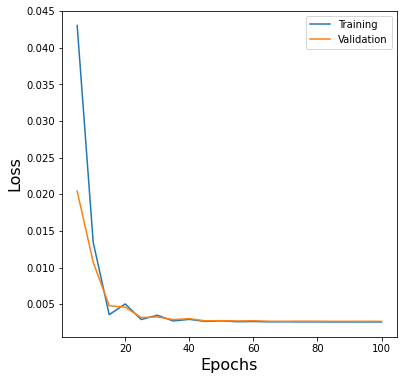

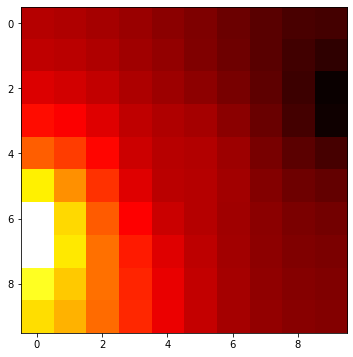

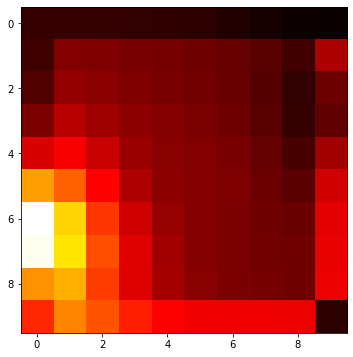

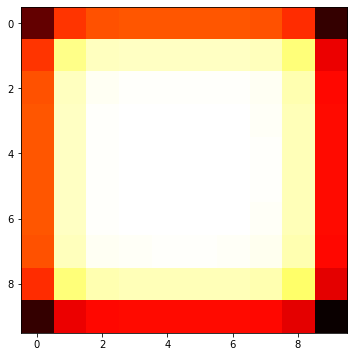

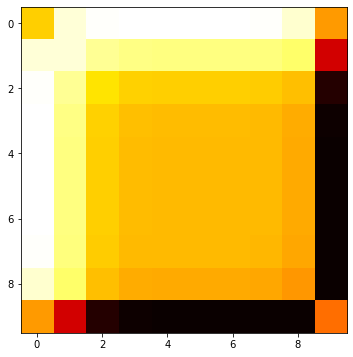

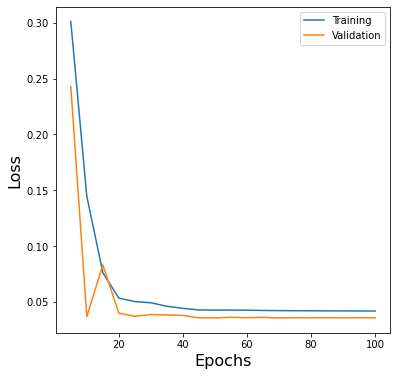

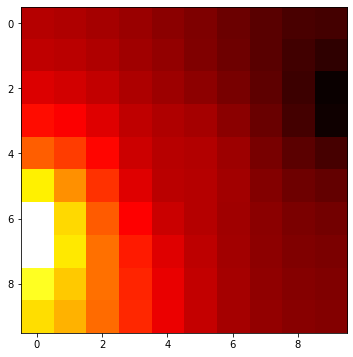

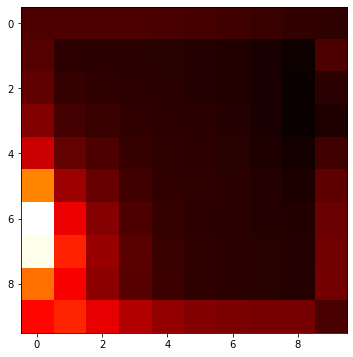

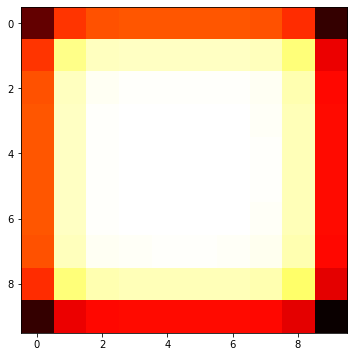

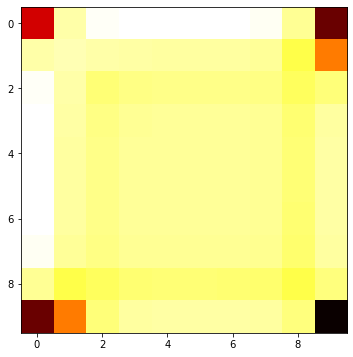

In [12]:
# First training
(model_continual, best_valid_loss) = training_continual(model_continual, train_dataset, test_dataset, 100, "_continual_round1")
print(f'Validation loss on original dataset after training the model on the original dataset: {best_valid_loss}')

pre_train_valid_loss_new = calculate_validation_loss(model_continual, test_dataset_new)
print(f'Validation loss on new dataset after training the model on the original dataset: {pre_train_valid_loss_new}')

i = 100
y_hat = model_continual(test_dataset[i].x, test_dataset[i].edge_index, test_dataset[i].edge_attr)
plot_heatmaps(test_dataset[i].y.detach().numpy(), y_hat.detach().numpy(), 'continualFirstTrainingOriginalDataset')

y_hat = model_continual(test_dataset_new[i].x, test_dataset_new[i].edge_index, test_dataset_new[i].edge_attr)
plot_heatmaps(test_dataset_new[i].y.detach().numpy(), y_hat.detach().numpy(), 'continualFirstTrainingNewDataset')

# Second training
(model_continual, best_valid_loss) = training_continual(model_continual, train_dataset_new, test_dataset_new, 100, "_continual_round2")
print(f'Validation loss on new dataset after training the model on the new dataset: {best_valid_loss}')

post_train_origset_valid_loss = calculate_validation_loss(model_continual, test_dataset)
print(f'Validation loss on original dataset after training the model on the new dataset: {post_train_origset_valid_loss}')

i = 100
y_hat = model_continual(test_dataset[i].x, test_dataset[i].edge_index, test_dataset[i].edge_attr)
plot_heatmaps(test_dataset[i].y.detach().numpy(), y_hat.detach().numpy(), 'continualSecondTrainingOriginalDataset')

y_hat = model_continual(test_dataset_new[i].x, test_dataset_new[i].edge_index, test_dataset_new[i].edge_attr)
plot_heatmaps(test_dataset_new[i].y.detach().numpy(), y_hat.detach().numpy(), 'continualSecondTrainingNewDataset')

# More comprehensive comparison

In [13]:
# Unify and then divide the dataset

# Unify the dataset
train_dataset, test_dataset = data_loader()
train_dataset_new, test_dataset_new = data_loader(flip=1, rotate=1, pathPrefix='./hpc_data/serial/output', normalizationFactor=1)
union_dataset = merge_datasets(merge_datasets(train_dataset, test_dataset), merge_datasets(train_dataset_new, test_dataset_new))

# Divide the dataset into 8 = 2^3
l1_dataset1, l1_dataset2 = temporal_signal_split(union_dataset, train_ratio=0.5)

l2_dataset1, l2_dataset2 = temporal_signal_split(l1_dataset1, train_ratio=0.5)
l2_dataset3, l2_dataset4 = temporal_signal_split(l1_dataset2, train_ratio=0.5)

l3_dataset1, l3_dataset2 = temporal_signal_split(l2_dataset1, train_ratio=0.5)
l3_dataset3, l3_dataset4 = temporal_signal_split(l2_dataset2, train_ratio=0.5)
l3_dataset5, l3_dataset6 = temporal_signal_split(l2_dataset3, train_ratio=0.5)
l3_dataset7, l3_dataset8 = temporal_signal_split(l2_dataset4, train_ratio=0.5)

divided_datasets = [l3_dataset1, l3_dataset2, l3_dataset3, l3_dataset4, l3_dataset5, l3_dataset6, l3_dataset7, l3_dataset8]

In [14]:
model = RecurrentGCN(node_features=input_lags)

model_continual = RecurrentGCN(node_features=input_lags)
model_continual._n_tot = 0 # Total number of parameters that the model has been trained on
model_continual._n_s_max = 100 # Number of training datapoints that would be stored in model_continual._stored_trainData
model_continual._stored_trainData = get_empty_dataset()

100%|██████████| 100/100 [03:47<00:00,  2.28s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 100/100 [04:39<00:00,  2.79s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 100/100 [03:35<00:00,  2.16s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 100/100 [06:38<00:00,  3.99s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 100/100 [03:41<00:00,  2.21s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 100/100 [07:35<00:00,  4.55s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 100/100 [03:40<00:00,  2.20s/

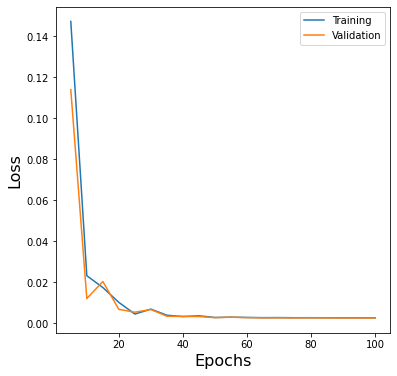

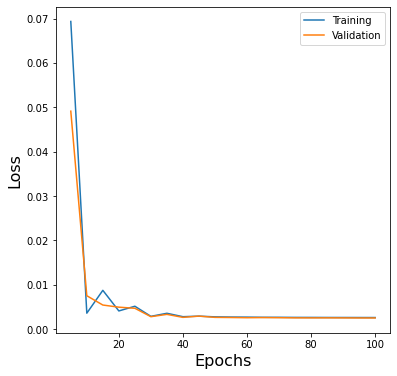

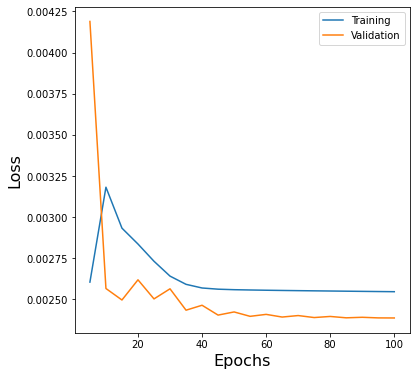

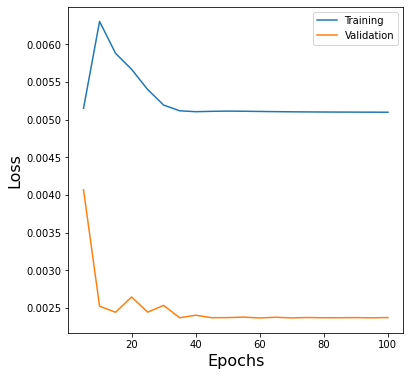

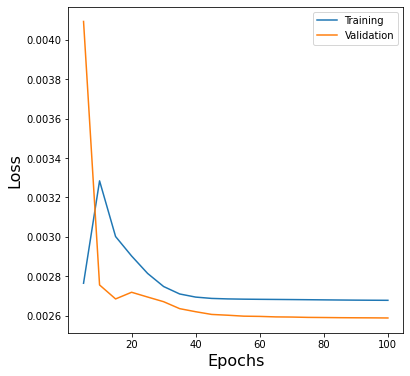

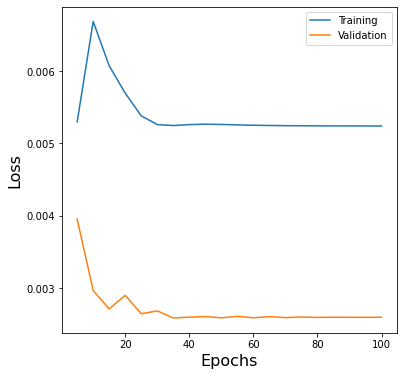

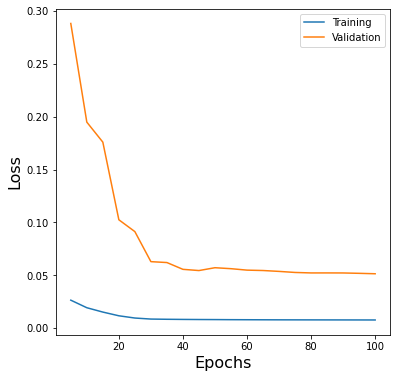

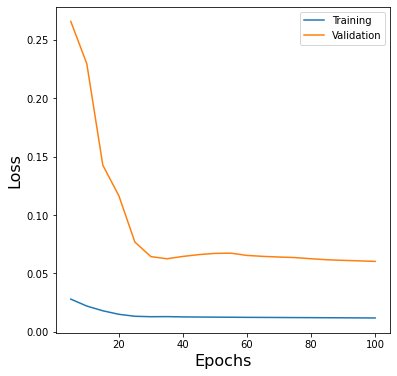

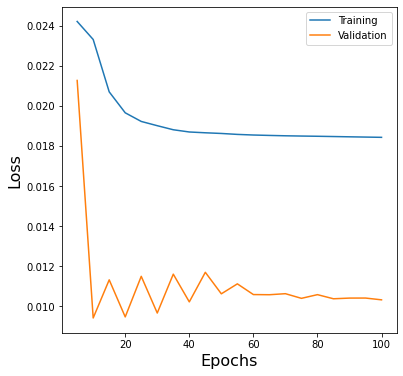

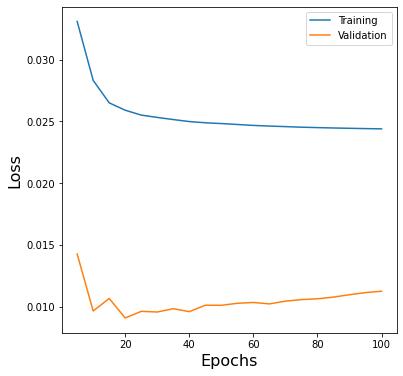

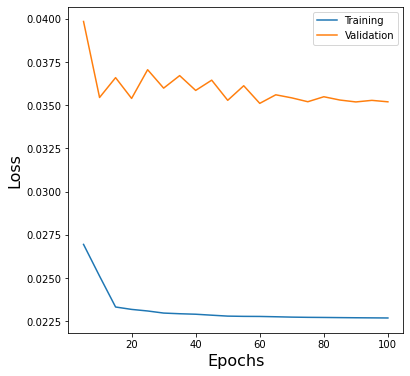

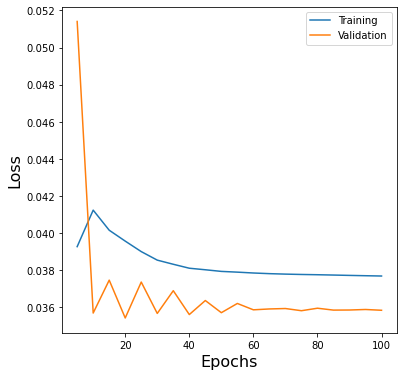

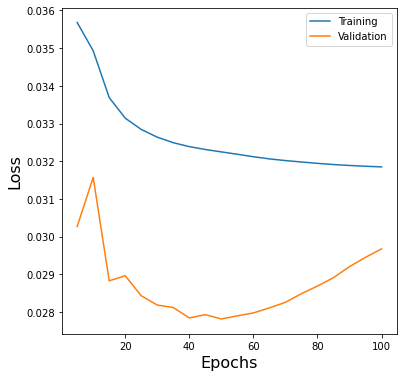

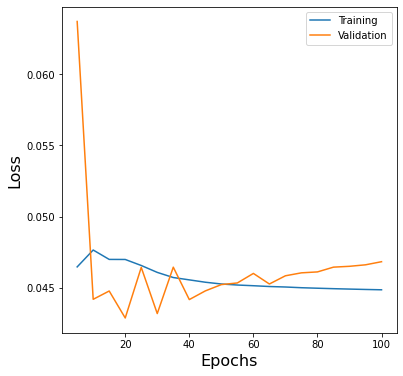

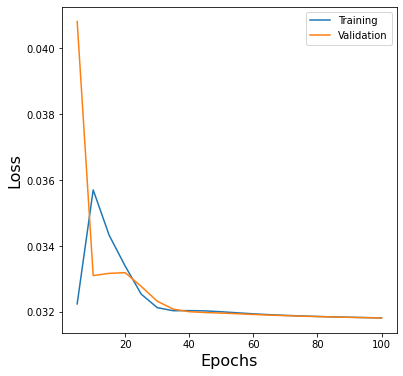

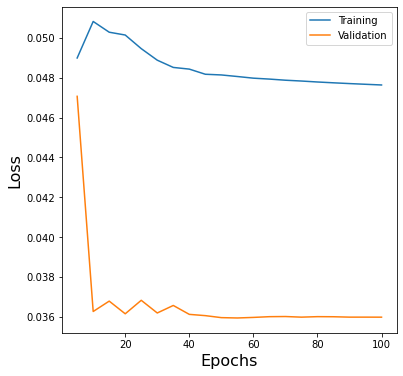

In [15]:
non_continual_val_loss_arr = []
continual_val_loss_arr = []

non_continual_val_loss_arr_on_first = []
continual_val_loss_arr_on_first = []

for j in range(8):
    train_dataset_split, test_dataset_split = temporal_signal_split(divided_datasets[j], train_ratio=0.8)
    if j == 0:
        first_validation_split = test_dataset_split
    (model, best_valid_loss) = training(model, train_dataset_split, test_dataset_split, 100, '_comparison_nonContinual' + str(j))
    (model_continual, best_valid_loss_continual) = training_continual(model_continual, train_dataset_split, test_dataset_split, 100, "_comparison_continual_round_" + str(j))

    non_continual_val_loss_arr.append(best_valid_loss)
    continual_val_loss_arr.append(best_valid_loss_continual)

    non_continual_val_loss_arr_on_first.append(calculate_validation_loss(model, first_validation_split))
    continual_val_loss_arr_on_first.append(calculate_validation_loss(model_continual, first_validation_split))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


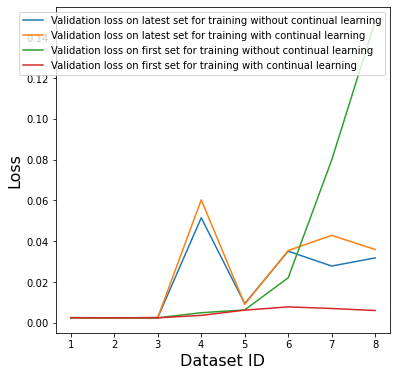

In [17]:
x_range = [*range(1, len(non_continual_val_loss_arr_on_first) + 1)]
plt.figure(figsize=(6, 6))
plt.plot(x_range, non_continual_val_loss_arr)
plt.plot(x_range, continual_val_loss_arr)
plt.plot(x_range, non_continual_val_loss_arr_on_first)
plt.plot(x_range, continual_val_loss_arr_on_first)
plt.xlabel('Dataset ID', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(["Validation loss on latest set for training without continual learning", \
            "Validation loss on latest set for training with continual learning", \
            "Validation loss on first set for training without continual learning", \
            "Validation loss on first set for training with continual learning"], loc ="upper right")
plt.savefig('comprehensive_comparison.eps', format='eps')